<h1>Problem Definition
<br> 

This problem is to design an automated trading solution for portfolio alloacation. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.
<br>
The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:
<br>
- Action: The action space describes the allowed actions that the agent interacts with the environment. Normally, a ∈ A represents the weight of a stock in the porfolio: a ∈ (-1,1). Assume our stock pool includes N stocks, we can use a list [a1, a2, ... , aN] to determine the weight for each stock in the porfotlio, where ai ∈ (-1,1), a1+ a2+...+aN=1. For example, "The weight of AAPL in the portfolio is 10%." is [0.1 , ...].
<br>
- Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s', i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively
<br>
- State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so our trading agent observes many different features to better learn in an interactive environment.
<br>
- Environment: Dow 30 consituents
<br>

The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.



In [ ]:
## install finrl library
%pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.finrl_meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys
sys.path.append("../FinRL-Library")

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [4]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [5]:
dp = YahooFinanceProcessor()
df = dp.download_data(start_date = '2008-01-01',
                     end_date = '2021-10-31',
                     ticker_list = config_tickers.DOW_30_TICKER, time_interval='1D')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
df.head()

,date,open,high,low,close,adjcp,volume,tic,day
0,2008-01-02,7.116786,7.152143,6.876786,6.958571,5.958445,1079178800,AAPL,2
1,2008-01-02,46.599998,47.040001,46.259998,46.599998,35.728569,7934400,AMGN,2
2,2008-01-02,52.090000,52.320000,50.790001,51.040001,40.477768,8053700,AXP,2
3,2008-01-02,87.570000,87.839996,86.000000,86.620003,63.481632,4303000,BA,2
4,2008-01-02,72.559998,72.669998,70.050003,70.629997,47.176804,6337800,CAT,2


In [7]:
df.shape

(101615, 9)

<h1>Preprocess Data
<br>

Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
<br>
- Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
<br>
- Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [8]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [9]:
df.shape

(97524, 17)

In [10]:
df.head()

,date,open,high,low,close,adjcp,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2008-01-02,7.116786,7.152143,6.876786,6.958571,5.958445,1079178800,AAPL,2,0.0,6.964725,6.955632,100.0,-66.666667,100.0,6.958571,6.958571
3483,2008-01-02,46.599998,47.040001,46.259998,46.599998,35.728569,7934400,AMGN,2,0.0,6.964725,6.955632,100.0,-66.666667,100.0,46.599998,46.599998
6966,2008-01-02,52.090000,52.320000,50.790001,51.040001,40.477768,8053700,AXP,2,0.0,6.964725,6.955632,100.0,-66.666667,100.0,51.040001,51.040001
10449,2008-01-02,87.570000,87.839996,86.000000,86.620003,63.481632,4303000,BA,2,0.0,6.964725,6.955632,100.0,-66.666667,100.0,86.620003,86.620003
13932,2008-01-02,72.559998,72.669998,70.050003,70.629997,47.176804,6337800,CAT,2,0.0,6.964725,6.955632,100.0,-66.666667,100.0,70.629997,70.629997


<h1>Add covariance matrix as states

In [11]:
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)
        

In [12]:
df.shape

(90468, 19)

In [13]:
df.head()

,date,open,high,low,close,adjcp,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,3.048214,2.610106,607541200,AAPL,2,-0.097446,3.649552,2.895305,42.254771,-80.847207,16.129793,3.243631,3.375887,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,57.750000,44.277359,6287200,AMGN,2,0.216368,58.947401,56.388599,51.060614,51.895357,10.432018,56.671334,56.044333,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,18.549999,14.908460,9625600,AXP,2,-1.191668,23.723023,16.106977,42.521170,-74.811722,25.776759,20.030000,22.412000,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,42.669998,32.005890,5443100,BA,2,-0.391219,42.894634,38.486366,47.290375,157.922391,5.366299,40.432000,43.304500,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,44.669998,30.628817,6277400,CAT,2,0.979845,45.785565,38.404435,51.073052,98.904653,26.331746,40.266000,39.918333,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...


<h1>Design Environment
<br>

Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a Markov Decision Process (MDP) problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

In [14]:
train = data_split(df, '2009-01-01','2020-07-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)

In [15]:
train.head()

,date,open,high,low,close,adjcp,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.775245,746015200,AAPL,4,-0.082758,3.633600,2.892864,45.440193,-30.508777,2.140064,3.244631,3.376833,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...
0,2009-01-02,58.590000,59.080002,57.750000,58.990002,45.228077,6547900,AMGN,4,0.320448,59.148360,56.339640,52.756859,94.549630,0.814217,56.759667,56.166000,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...
0,2009-01-02,18.570000,19.520000,18.400000,19.330000,15.535344,10955700,AXP,4,-1.059847,23.489423,16.086577,43.923322,-42.018825,16.335101,20.028333,22.263333,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...
0,2009-01-02,42.799999,45.560001,42.779999,45.250000,33.941093,7010200,BA,4,-0.019566,43.926849,37.932151,50.664690,275.696308,20.494464,40.621667,43.237334,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...
0,2009-01-02,44.910000,46.980000,44.709999,46.910000,32.164722,7117200,CAT,4,1.248426,46.543072,38.372928,53.534743,131.675975,34.637448,40.623333,39.911333,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...


<h1>Environment for Portfolio Allocation

In [16]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 28, State Space: 28


In [17]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [18]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<h1> Implement DRL Algorithms

In [19]:
agent = DRLAgent(env = env_train)

In [20]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device


In [21]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000)

-------------------------------------
| time/                 |           |
|    fps                | 190       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -39.6     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 1.71e+08  |
|    reward             | 1529830.1 |
|    std                | 0.997     |
|    value_loss         | 2.45e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 196       |
|    iterations         | 200       |
|    time_elapsed       | 5         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -39.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updat

In [22]:
trained_a2c.save('/content/trained_a2c.zip')

<h1>PPO

In [23]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device


In [24]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=80000)

----------------------------------
| time/              |           |
|    fps             | 248       |
|    iterations      | 1         |
|    time_elapsed    | 8         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 3446867.2 |
----------------------------------
begin_total_asset:1000000
end_total_asset:4472618.7885467205
Sharpe:  0.805668966457915
--------------------------------------------
| time/                   |                |
|    fps                  | 238            |
|    iterations           | 2              |
|    time_elapsed         | 17             |
|    total_timesteps      | 4096           |
| train/                  |                |
|    approx_kl            | 1.19325705e-08 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -39.7          |
|    explained_variance   | 0              |
|    learning_rate        | 0.0001         |
|    loss   

In [25]:
trained_ppo.save('/content/trained_ppo.zip')

<h1>DDPG

In [26]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [27]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:4462866.808014206
Sharpe:  0.8055384073381935
begin_total_asset:1000000
end_total_asset:4659733.836927422
Sharpe:  0.8281213128058811
begin_total_asset:1000000
end_total_asset:4659733.836927422
Sharpe:  0.8281213128058811
begin_total_asset:1000000
end_total_asset:4659733.836927422
Sharpe:  0.8281213128058811
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 86        |
|    time_elapsed    | 133       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | -8.01e+07 |
|    critic_loss     | 4.49e+12  |
|    learning_rate   | 0.001     |
|    n_updates       | 8679      |
|    reward          | 4659734.0 |
----------------------------------
begin_total_asset:1000000
end_total_asset:4659733.836927422
Sharpe:  0.8281213128058811
begin_total_asset:1000000
end_total_asset:4659733.836927422
Sharpe:  0.8281213128058811
begin_total_asset

In [28]:
trained_ddpg.save('/content/trained_ddpg.zip')

<h1>SAC

In [29]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [30]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:4385150.939613024
Sharpe:  0.8047460289713315
begin_total_asset:1000000
end_total_asset:4257109.0517413765
Sharpe:  0.7941476351161308
begin_total_asset:1000000
end_total_asset:4257118.304362022
Sharpe:  0.7941477284465385
begin_total_asset:1000000
end_total_asset:4257047.314563772
Sharpe:  0.7941398670325963
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 46        |
|    time_elapsed    | 250       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | -1.08e+08 |
|    critic_loss     | 6.63e+11  |
|    ent_coef        | 3.24      |
|    ent_coef_loss   | -184      |
|    learning_rate   | 0.0003    |
|    n_updates       | 11471     |
|    reward          | 4257047.5 |
----------------------------------
begin_total_asset:1000000
end_total_asset:4257787.466721124
Sharpe:  0.7942201031405552
begin_total_asset:1000000
end_tota

In [31]:
trained_sac.save('/content/trained_sac.zip')

<h1>TD3

In [32]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


In [33]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

begin_total_asset:1000000
end_total_asset:4554734.2553370325
Sharpe:  0.8137987509119097
begin_total_asset:1000000
end_total_asset:4423500.230308581
Sharpe:  0.792206583453917
begin_total_asset:1000000
end_total_asset:4423500.230308581
Sharpe:  0.792206583453917
begin_total_asset:1000000
end_total_asset:4423500.230308581
Sharpe:  0.792206583453917
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 93        |
|    time_elapsed    | 123       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | -4.26e+07 |
|    critic_loss     | 2.77e+12  |
|    learning_rate   | 0.001     |
|    n_updates       | 8679      |
|    reward          | 4423500.0 |
----------------------------------
begin_total_asset:1000000
end_total_asset:4423500.230308581
Sharpe:  0.792206583453917
begin_total_asset:1000000
end_total_asset:4423500.230308581
Sharpe:  0.792206583453917
begin_total_asset:100

In [35]:
trained_td3.save('/content/trained_td3.zip')

<h1>Trading
<br>

Assume that we have $1,000,000 initial capital at 2019-01-01. We use the A2C model to trade Dow jones 30 stocks.

In [36]:
trade = data_split(df,'2020-07-01', '2021-10-31')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [37]:
trade.shape

(9436, 19)

In [38]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1385890.8172226318
Sharpe:  1.831844921873963
hit end!


In [39]:
df_daily_return.head()

,date,daily_return
0,2020-07-01,0.000000
1,2020-07-02,0.004390
2,2020-07-06,0.015601
3,2020-07-07,-0.013293
4,2020-07-08,0.006268


In [40]:
df_daily_return.to_csv('df_daily_return.csv')

In [41]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,...,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714
2020-07-02,0.024936,0.024936,0.042504,0.033741,0.054676,0.024936,0.040625,0.041679,0.055642,0.024936,...,0.033644,0.024936,0.067784,0.036035,0.038992,0.026227,0.026173,0.039027,0.043296,0.041141
2020-07-06,0.024936,0.024936,0.042504,0.033741,0.054676,0.024936,0.040625,0.041679,0.055642,0.024936,...,0.033644,0.024936,0.067784,0.036035,0.038992,0.026227,0.026173,0.039027,0.043296,0.041141
2020-07-07,0.024936,0.024936,0.042504,0.033741,0.054676,0.024936,0.040625,0.041679,0.055642,0.024936,...,0.033644,0.024936,0.067784,0.036035,0.038992,0.026227,0.026173,0.039027,0.043296,0.041141
2020-07-08,0.024936,0.024936,0.042504,0.033741,0.054676,0.024936,0.040625,0.041679,0.055642,0.024936,...,0.033644,0.024936,0.067784,0.036035,0.038992,0.026227,0.026173,0.039027,0.043296,0.041141


In [42]:
df_actions.to_csv('df_actions.csv')

<h1> BackTestStats

In [43]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [44]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.276384
Cumulative returns     0.385891
Annual volatility      0.138499
Sharpe ratio           1.831845
Calmar ratio           3.145079
Stability              0.901207
Max drawdown          -0.087878
Omega ratio            1.356021
Sortino ratio          2.791775
Skew                  -0.095320
Kurtosis               1.428528
Tail ratio             1.098450
Daily value at risk   -0.016442
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [45]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (336, 8)
Annual return          0.279047
Cumulative returns     0.388402
Annual volatility      0.139129
Sharpe ratio           1.844560
Calmar ratio           3.124551
Stability              0.918675
Max drawdown          -0.089308
Omega ratio            1.358960
Sortino ratio          2.734872
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016510
dtype: float64


<h1>BackTestPlot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (337, 8)


Start date,2020-07-01
End date,2021-10-29
Total months,16
,Backtest
Annual return,27.638%
Cumulative returns,38.589%
Annual volatility,13.85%
Sharpe ratio,1.83
Calmar ratio,3.15
Stability,0.90
Max drawdown,-8.788%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.79,2020-09-02,2020-10-28,2020-11-09,49
1,4.79,2021-08-16,2021-09-30,NaT,NaN
2,4.00,2021-06-04,2021-06-18,2021-07-12,27
3,3.45,2021-01-20,2021-01-29,2021-02-05,13
4,3.21,2021-02-24,2021-03-04,2021-03-10,11


Stress Events,mean,min,max
New Normal,0.10%,-3.38%,3.93%


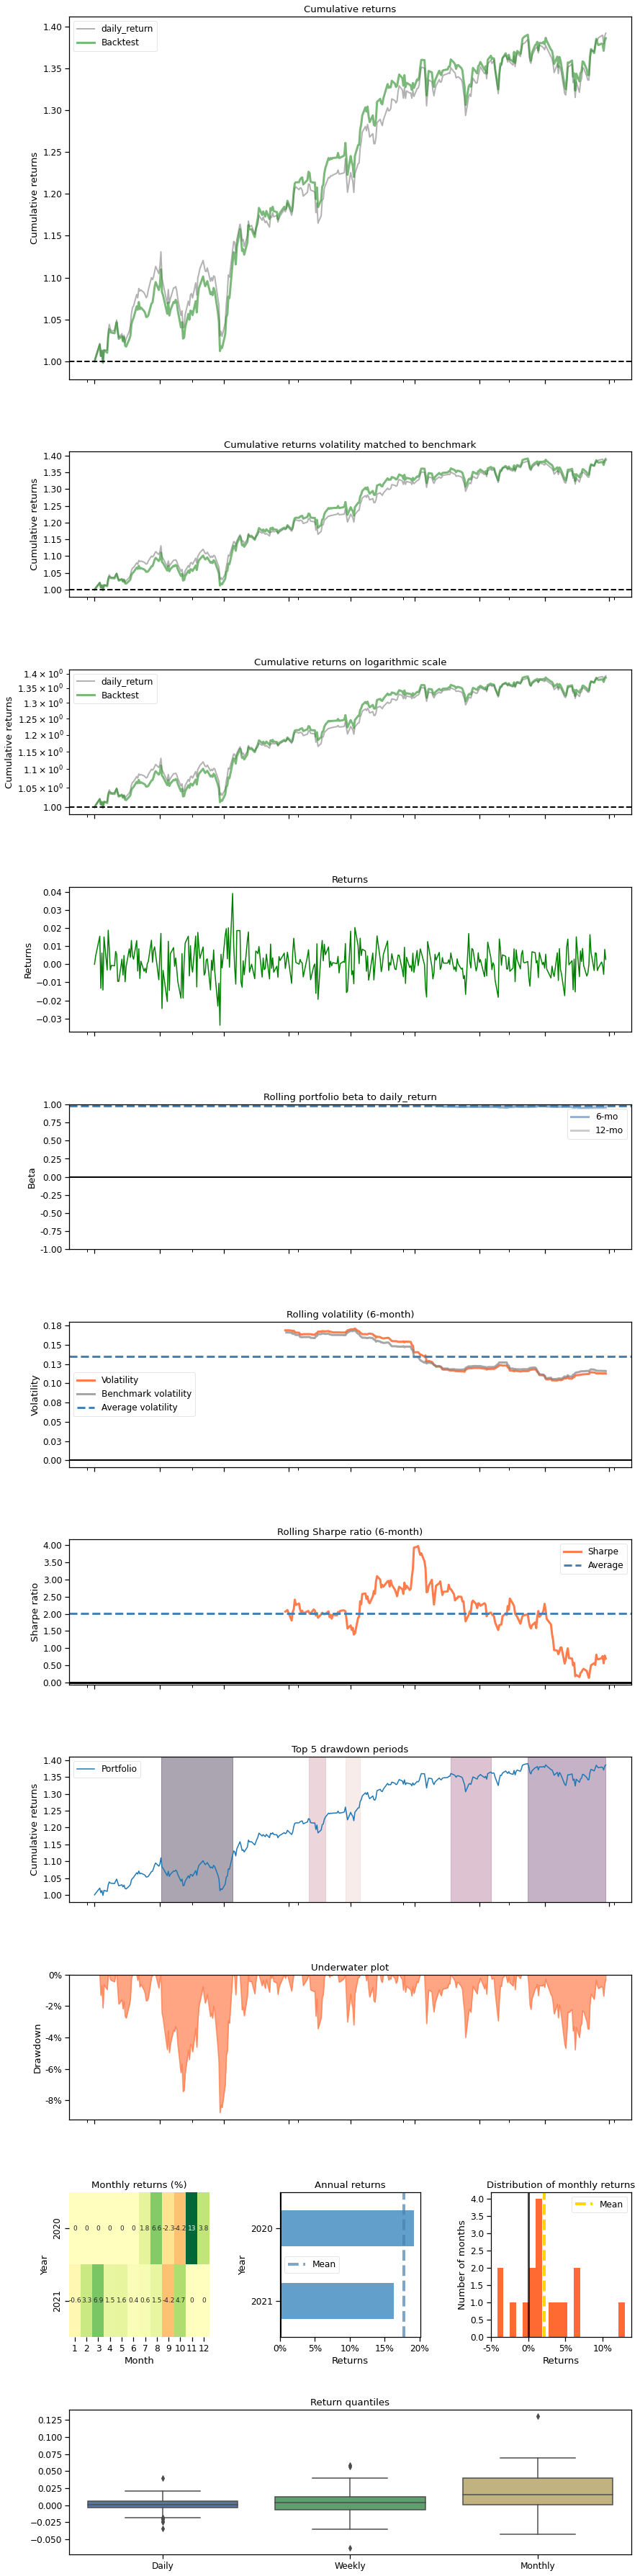

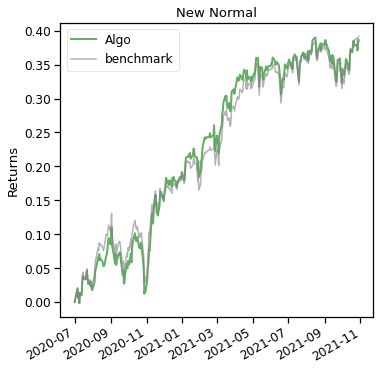

In [46]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return.loc[0,'date'], end='2021-11-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

<h1>Min-Variance Portfolio Allocation

In [47]:
%pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 3.3 MB/s 
     |████████████████████████████████| 2.8 MB 11.2 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [48]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [49]:
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [50]:
df.head()

,date,open,high,low,close,adjcp,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,3.048214,2.610106,607541200,AAPL,2,-0.097446,3.649552,2.895305,42.254771,-80.847207,16.129793,3.243631,3.375887,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,57.750000,44.277359,6287200,AMGN,2,0.216368,58.947401,56.388599,51.060614,51.895357,10.432018,56.671334,56.044333,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,18.549999,14.908460,9625600,AXP,2,-1.191668,23.723023,16.106977,42.521170,-74.811722,25.776759,20.030000,22.412000,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,42.669998,32.005890,5443100,BA,2,-0.391219,42.894634,38.486366,47.290375,157.922391,5.366299,40.432000,43.304500,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,44.669998,30.628817,6277400,CAT,2,0.979845,45.785565,38.404435,51.073052,98.904653,26.331746,40.266000,39.918333,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...


In [51]:
#calculate_portfolio_minimum_variance
portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()
    
    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value 
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
    
portfolio=portfolio.T
portfolio.columns = ['account_value']

In [52]:
portfolio.head()

,account_value
2020-07-01,1000000
2020-07-02,1005234.883501
2020-07-06,1014933.780399
2020-07-07,1014238.666671
2020-07-08,1012674.038646


In [53]:
a2c_cumpod =(df_daily_return.daily_return+1).cumprod()-1

In [54]:
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1

In [55]:
dji_cumpod =(baseline_returns+1).cumprod()-1

<h1>Plotly: DRL, Min-Variance, DJIA

In [56]:
%pip install plotly

In [57]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [58]:
time_ind = pd.Series(df_daily_return.date)

In [59]:
trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C (Portfolio Allocation)')

trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')

In [60]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)

fig.add_trace(trace1_portfolio)

fig.add_trace(trace2_portfolio)



fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()